In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

import numpyro
import math
import jax
import jax.numpy as jnp
import jax.random as jr
import numpy as np
import matplotlib.pyplot as plt

from jax import random
from numpyro.infer import MCMC, NUTS

import numpyro.distributions as dist

import arviz as az

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class Wind:
    def __init__(self, speed, direction):
        self.speed = speed # a function over time
        self.direction = direction # a tuple in the form of (x,y)

    def angle(self): # the angle between the velocity and the east-west direction
        theta = math.atan2(self.direction[1], self.direction[0])
        return theta
  
    def velocity(self):
        x = self.speed * math.cos(self.angle())
        y = self.speed * math.sin(self.angle())
        return (x,y)

In [4]:
class Signal:
    def __init__(self, N_p, lw, hi):
        self.input = np.random.uniform(low=lw, high=hi, size=2*N_p) # twice the pixels because the signal is moving

    def moving_velocity(self, wind):
        vel = wind.velocity()
        return vel

    def signal_func(self, time, wind, N_p): # one dimensional
        signal_t = []
        vel = self.moving_velocity(wind)[0]
        for i in range(N_p):
            signal_t.append(self.input[i-int(time*vel)])
        # print(vel, time, int(time*vel))
        signal_t = np.array(signal_t)
        return signal_t

In [5]:
class Data:
    def __init__(self, signal, PM, size):
        self.signal = signal
        self.PM = PM
        self.size = size
        self.input = None

    def add_small_noise(self):
        noise = np.random.randn(self.size) * 10
        return self.input + noise
    
    def add_large_noise(self):
        noise = np.random.randn(self.size) * 50
        return self.input + noise

In [6]:
# N_d: number of detectors; N_t: number of times data is detected by each detector; N_p: number of pixels
# signal: data of signal (which in this case is modeled to be a sine function in each pixel)
N_d, N_t, N_p = 10, 150 * 10, 10

In [7]:
wind = Wind(0.5, (-1,0))
signal_pack = Signal(N_p, 5, 30)
signal = signal_pack.input

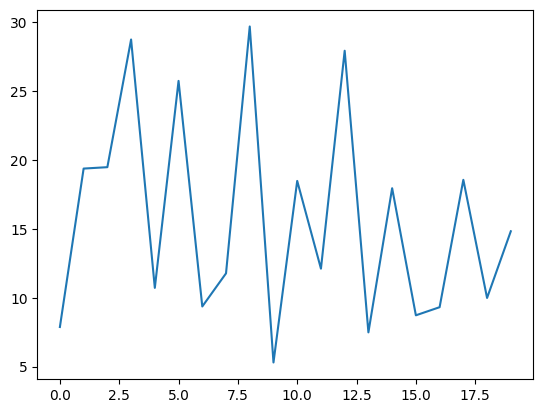

In [8]:
plt.plot(signal)

In [9]:
P_encoded = list()

for i in range(N_d):
    for row in range(N_t*N_p):
        for col in range(N_p):
                if ((row / 150) // (10 / 10) == col):
                    if ((row + i * 9) / 150) // (10 / 10) < N_t: # 9 because 9/150 = 0.06, when each detector is 0.06 from the adjacent ones
                        P_encoded.append(int(((row + i * 9) / 150) // (10 / 10)))
                    else: 
                        P_encoded.append(col)
          
P_encoded = np.array(P_encoded)
print(np.shape(P_encoded))

(15000,)


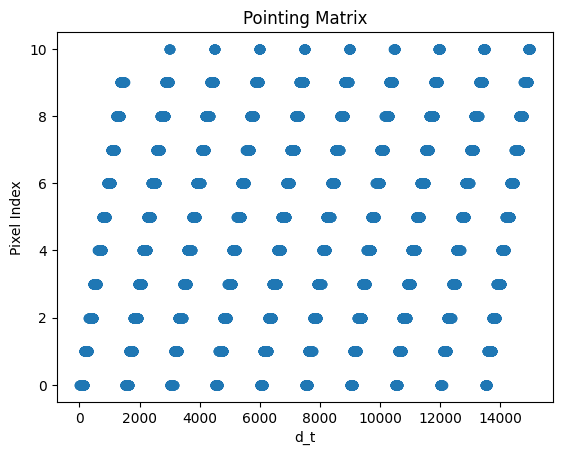

In [10]:
plt.scatter(range(len(P_encoded)), P_encoded)
plt.xlabel("d_t")
plt.ylabel("Pixel Index")
plt.title("Pointing Matrix")
plt.show()

In [11]:
data_pack = Data(signal, P_encoded, N_t*N_d)

In [14]:
input = []
for time_ind in range(N_t*N_d):
    output = signal_pack.signal_func((time_ind%N_t)/150., wind, N_p)
    # print(np.shape(output))
    input.append(output[P_encoded][time_ind])
input = np.array(input)

data_pack.input = input

IndexError: index 10 is out of bounds for axis 0 with size 10

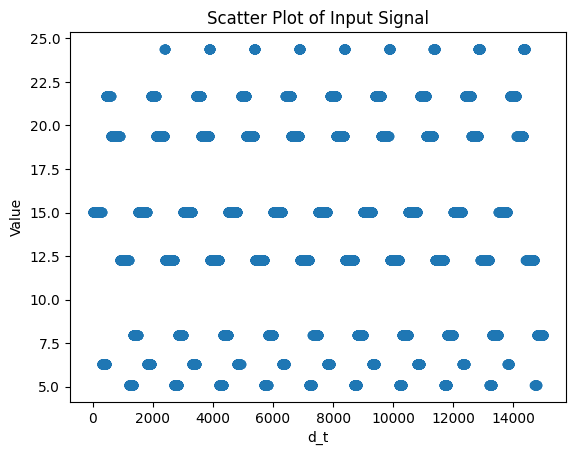

In [12]:
# Scatter Plot of Input Signals

plt.scatter(range(len(input)), input)
plt.xlabel("d_t")
plt.ylabel("Value")
plt.title("Scatter Plot of Input Signal")
plt.show()

In [13]:
Data_small_noise_1 = data_pack.add_small_noise()
Data_large_noise_1 = data_pack.add_large_noise()

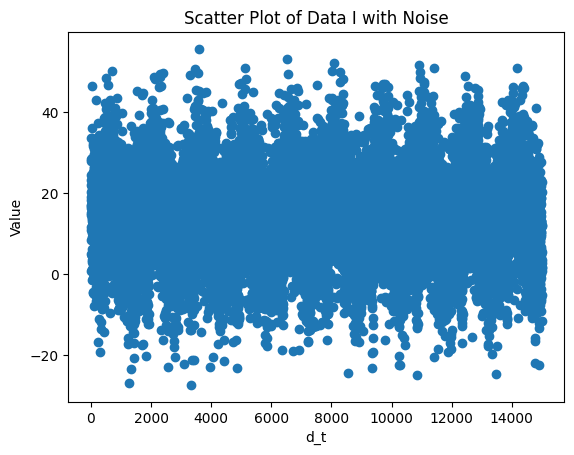

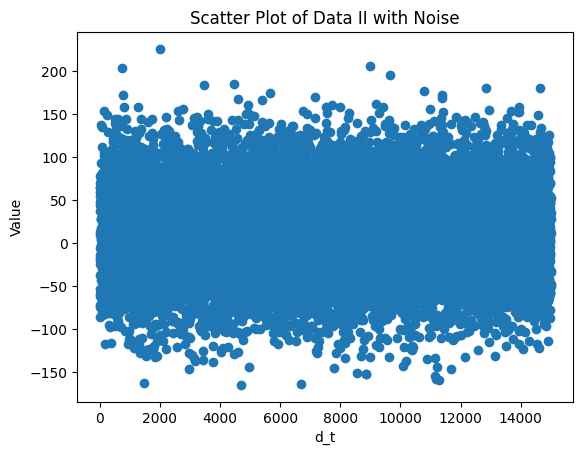

In [14]:
# Scatter Plot of Data

plt.scatter(range(len(Data_small_noise_1)), Data_small_noise_1)
plt.xlabel("d_t")
plt.ylabel("Value")
plt.title("Scatter Plot of Data I with Noise")
plt.show()

plt.scatter(range(len(Data_large_noise_1)), Data_large_noise_1)
plt.xlabel("d_t")
plt.ylabel("Value")
plt.title("Scatter Plot of Data II with Noise")
plt.show()

In [15]:
rng_key = random.PRNGKey(0)

In [16]:
def model_func_1():
        s = numpyro.sample("s", dist.Uniform(low=jnp.full(N_p*N_d,-30), high=jnp.full(N_p,100)))
        # d = PM_converted @ s
        d = s[P_encoded]
        print(d.shape)
        d_noised = numpyro.sample("d_noised", dist.Normal(d,10.), obs=Data_small_noise_1)
        return d_noised

nuts_kernel_1 = NUTS(model_func_1)
mcmc_1 = MCMC(nuts_kernel_1, num_warmup=100, num_samples=100)
mcmc_1.run(rng_key)

ValueError: Incompatible shapes for broadcasting: shapes=[(), (100,), (10,)]

In [ ]:
def model_func_2():
        s = numpyro.sample("s", dist.Uniform(low=jnp.full(N_p*N_d,-30), high=jnp.full(N_p,100)))
        d = s[P_encoded]
        print(d.shape)
        d_noised = numpyro.sample("d_noised", dist.Normal(d,50.), obs=Data_large_noise_1)
        return d_noised

nuts_kernel_2 = NUTS(model_func_2)
mcmc_2 = MCMC(nuts_kernel_2, num_warmup=100, num_samples=100)
mcmc_2.run(rng_key)